## Convocatoria 1 - Proyecto 1

**Nota:** Se ha añadido un pequeña parte extra al final de la actividad.

In [1]:
# Importar librerías
from scipy.ndimage import binary_fill_holes as bfh
from skimage import io, morphology
from skimage.morphology import convex_hull_image
from skimage.measure import label
from skimage.measure import regionprops
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
from tabulate import tabulate
import math
import pandas as pd
import numpy as np

#### 0) Cargar una de las imágenes histológicas

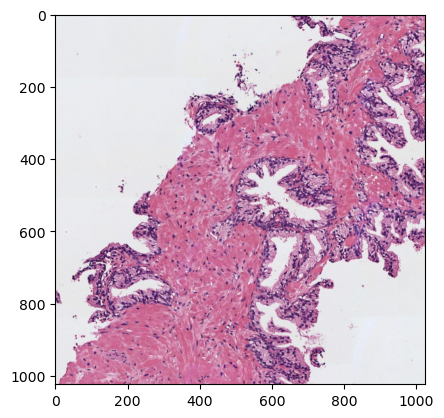

In [2]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.

# Leer la imagen en RGB
img_path = 'histo_1.jpg'
img = io.imread(img_path) #imread hyperparamter 0 para leer en escala de grises

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
img_norm = img / 255.0

# Visualizar la imagen
plt.imshow(img_norm)
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

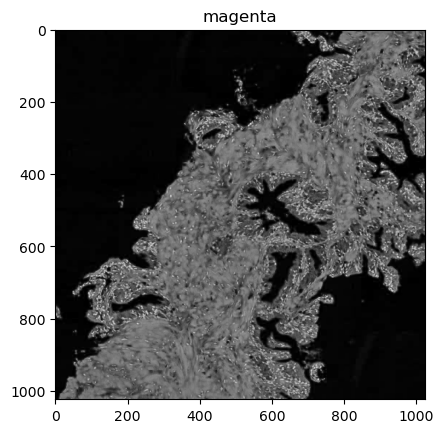

In [3]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
img_copy = img_norm.copy()

# RGB to CMYK | Extraer canales CMYK
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img_copy, axis=2)
    C = (1-img_copy[:,:,0]-K)/(1-K) # diapositiva 17 ppt. tema 3
    M = (1-img_copy[:,:,1]-K)/(1-K) # diapositiva 17 ppt. tema 3
    Y = (1-img_copy[:,:,2]-K)/(1-K) # diapositiva 17 ppt. tema 3

# Juntar los 4 canales CMYK para formar una imagen
CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
# el método split extrae los diferentes canales, en lugar de hacer slicing por canales.
C,M,Y,K = cv2.split(CMYK)

# Visualizar la imagen del canal magenta
plt.imshow(M.astype('uint8'), cmap='gray')
plt.title('magenta')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

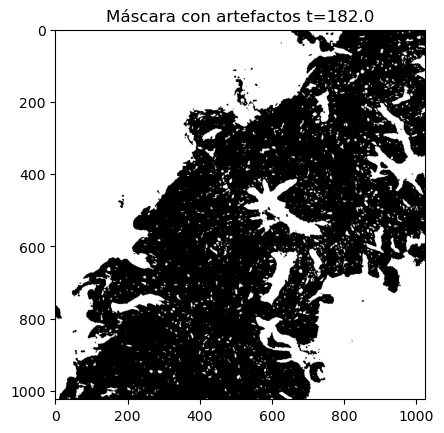

In [4]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
img_gauss = cv2.GaussianBlur(img_norm, (5,5), 0) 

# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
img_gray = (img_gauss * 255).astype(np.uint8) # Multiplicar por 255 para el rango [0-255]
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_RGB2GRAY) # Pasar a grises
t, mask1 = cv2.threshold(img_gray,0,1,cv2.THRESH_OTSU) # Convertir en binario mediante Otsu

# Visualizar la máscara resultante
plt.imshow(mask1, cmap='gray')
plt.title('Máscara con artefactos t=' + str(t))
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

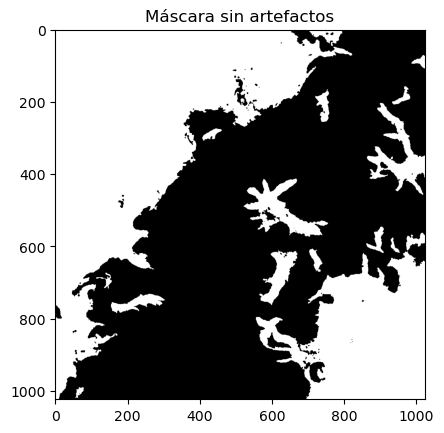

In [5]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
mask2 = morphology.remove_small_objects(mask1.astype(bool), min_size=300) # Eliminar artefactos

# Visualizar la máscara resultante
plt.imshow(mask2, cmap='gray')
plt.title('Máscara sin artefactos')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

**Manera manual**

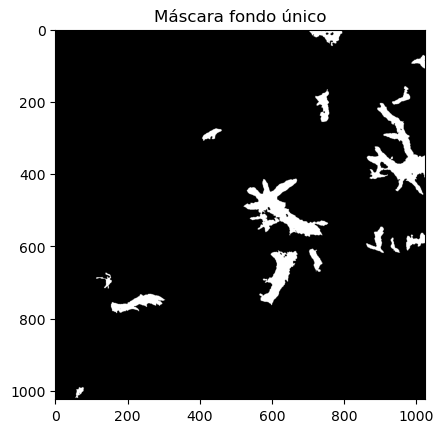

In [6]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
mask3 = mask2.copy().astype(np.uint8)

# Definir una imagen negra de referencia con dos píxeles adicionales en cada dirección
h, w = mask3.shape
ref = np.zeros((h + 2, w + 2), np.uint8)

# Hacer flooding de la imagen con 2 semillas
cv2.floodFill(mask3, ref, (100, 100), 0)
cv2.floodFill(mask3, ref, (850, 850), 0)

# Visualizar la máscara resultante.
plt.imshow(mask3, cmap='gray')
plt.title('Máscara fondo único')
plt.show()

**Manera semiautomática:**

- Dividir la máscara binaria por área de regiones en tamaño descendente.
- Seleccionar las 2 áreas de mayor tamaño
- Aplicar cv2.floodFill() a las 2 áreas de mayor tamaño. -> Por esto es semiautomático: Hay que contar el número de área inconexas que no corresponden a lúmenes. Únicamente ahorra el tener que introducir semillas.

Introducir n° de áreas inconexas: 2


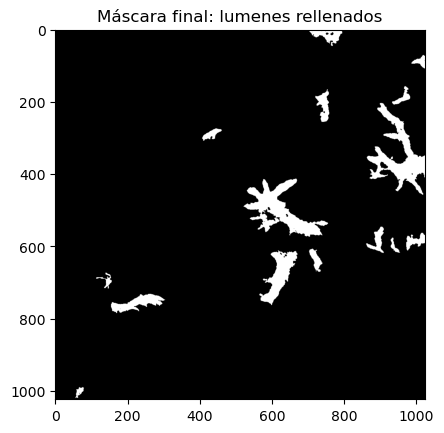

In [7]:
# Dividir la máscara binaria por área de regiones
labeled_mask = label(mask2)
props = regionprops(labeled_mask) # Calcular propiedades de cada region (label)

# Ordenar en orden descendente las áreas de las regiones
props.sort(key=lambda x: x.area, reverse=True)

# crear copia de la máscara
mask2_copy = mask2.astype(np.uint8)

num_areas = int(input("Introducir n° de áreas inconexas: "))

seed_point = [None]*num_areas
for i in range(num_areas):
    # Obtener el centro de gravedad (centroid) de las dos regiones más grandes
    seed_point[i] = (int(props[i].centroid[1]), int(props[i].centroid[0]))  # Intercambiar x e y para floodFill

    # Aplicar floodFill
    cv2.floodFill(mask2_copy, None, seed_point[i], 0)

# Visualizar la imagen
plt.imshow(mask2_copy, cmap='gray')
plt.title('Máscara final: lumenes rellenados')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

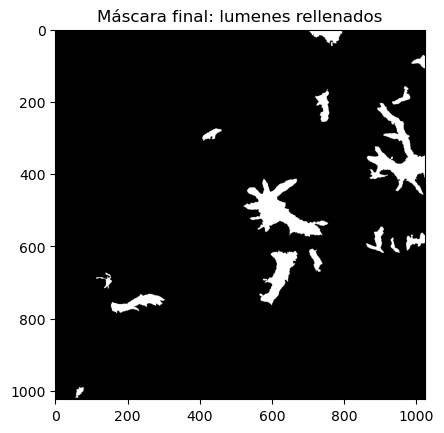

In [8]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
mask4 = mask3.copy()
mask5 = bfh(mask4) # mask5 es la máscara rellena

# Visualizar la máscara resultante
plt.imshow(mask5, cmap='gray')
plt.title('Máscara final: lumenes rellenados')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

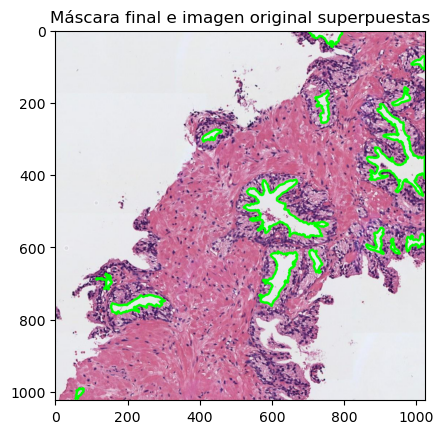

In [9]:
# # Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# # para que los contornos en verde sean perfectamente visibles. 

# Encontrar contornos sobre la máscara del apartado 5)
contours, _ = cv2.findContours(mask5.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar los contornos sobre la imagen original
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 5)

# Visualizar la imagen superpuesta
plt.imshow(img_contours)
plt.title('Máscara final e imagen original superpuestas')
plt.show()

#### 7) Identificar y cropear el lumen más grande

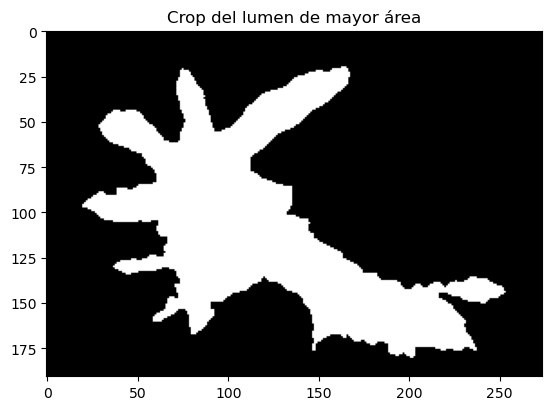

In [10]:
# Encontrar el lumen de mayor área
max_area = 0
max_contour = None

for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        max_contour = contour

# Crop del lumen de mayor área sobre mask5 (apdo. 5)
x, y, w, h = cv2.boundingRect(max_contour)
cropped_lumen = mask5[-20+y:y+h+10, -20+x:x+w+20] # Ajustamos un poco el tamaño de la imagen

# Visualizar el lumen de mayor área
plt.imshow(cropped_lumen, cmap='gray')
plt.title('Crop del lumen de mayor área')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [11]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

Obtener la bounding box y la convex hull image

In [12]:
# Copia de la máscara recortada (cropped)
mask6 = cropped_lumen.copy().astype('uint8')
imagen = img.copy()

# Obtener BBox
prop = regionprops(mask6)
bbox = prop[0].bbox
imagen = cv2.rectangle(imagen, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 5)
                   
# Obtener convex_hull_image
convex_image = convex_hull_image(mask6)

# plt.imshow(imagen, cmap='gray')
# plt.title('Convex Hull Contour Overlaid on Original Image')
# plt.show()

In [13]:
# Análisis geométrico del lumen

# Indices de filas
index = ['area', 'bbox_area', 'convex_area', 'eccentricity', 'equiv_diameter',
         'extent', 'max Feret diameter', 'major_axis', 'minor_axis', 'orientation', 'perimeter',
         'solidity', 'compactness']

# Descriptores geométricos formato diccionario
data = {
    'lumen': [
        np.round(prop[0].area, 4),
        np.round(prop[0].bbox_area, 4),
        np.round(prop[0].convex_area, 4),
        np.round(prop[0].eccentricity, 4),
        np.round(prop[0].equivalent_diameter, 4),
        np.round(prop[0].extent, 4),
        np.round(prop[0].feret_diameter_max, 4),
        np.round(prop[0].major_axis_length, 4),
        np.round(prop[0].minor_axis_length, 4),
        np.round(prop[0].orientation, 4),
        np.round(prop[0].perimeter, 4),
        np.round(prop[0].solidity, 4),
        np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4)
    ]
}

# Crear DataFrame
df = pd.DataFrame(data, index=index)

# Mostrar resultados
display(df)

,lumen
area,13409.0000
bbox_area,37674.0000
convex_area,27629.0000
eccentricity,0.8444
equiv_diameter,130.6632
extent,0.3559
max Feret diameter,243.4625
major_axis,231.7770
minor_axis,124.1668
orientation,0.9966


# Parte extra

- Etiquetas a los lúmenes y visualizar los lumenes etiquetados
- Calcular las áres de los lúmenes y devolver automáticamente la etiqueta del lumen de mayor área
- Calcular bounding box y convex hull image para el lumen de mayor área y representarlos sobre la imagen original.

número de objetos:  15
posibles valores de intensidad:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


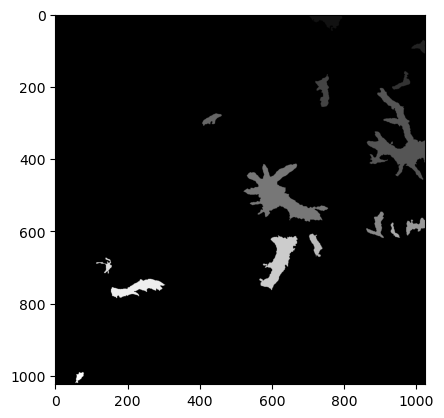

In [14]:
# Identificar cada objeto
lab, num = label(mask5, return_num=True)

# Imprimir por pantalla
print('número de objetos: ', num)
v,c = np.unique(lab, return_counts=True)
print('posibles valores de intensidad: ', v)

# Visualizar los diferentes lumenes (regiones)
plt.imshow(lab, cmap='gray')
plt.show()

In [15]:
# Calcular propiedades diversas de cada lumen (región)
regions = regionprops(lab)

# Encontrar el índice del lumen de mayor área
largest_area = 0
largest_area_index = None
for i, region in enumerate(regions):
    if region.area > largest_area:
        largest_area = region.area
        largest_area_index = i

# Obtener el lumen de mayor area
largest_lumen_label = lab[regions[largest_area_index].coords[0][0], regions[largest_area_index].coords[0][1]]

# Imprimir por pantalla lumen de mayor área
print("Etiqueta del lumen de mayor área", largest_lumen_label)


Etiqueta del lumen de mayor área 7


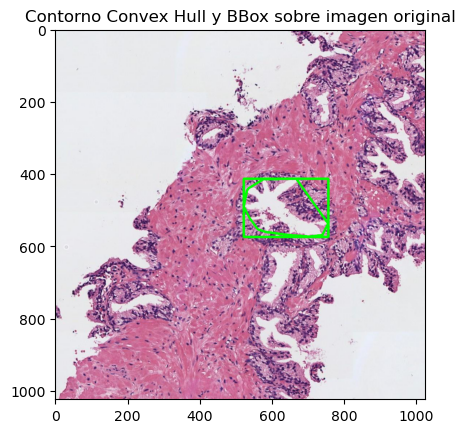

In [18]:
# Preparar formato imagen original y objeto (lumen)
imagen = img.copy()
objeto = lab == largest_lumen_label
objeto = objeto.copy().astype('uint8')

# Obtener BBox
prop = regionprops(objeto)
bbox = prop[0].bbox
imagen = cv2.rectangle(imagen, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (0, 255, 0), 5)
                   
# Obtener convex_hull_image
convex_image = convex_hull_image(objeto)
convex_image = convex_image.astype('uint8')

# Encontrar y dibujar contornos
conts,_ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Encontrar cotornos
imagen = cv2.drawContours(imagen, conts, -1, (0,255,0), 5) # Dibujar los contornos con grosor 5.


# Visualizar la imagen
plt.imshow(imagen, cmap='gray')
plt.title('Contorno Convex Hull y BBox sobre imagen original')
plt.show()